In [1]:
import sys
from datasets import load_dataset
from loguru import logger

logger.configure(handlers=[{"sink": sys.stdout, "level": "WARNING"}])
ds = load_dataset("CharlyR/vtikz", "tikz", split="benchmark")
ds = ds.select_columns(["id","type","instruction","code","template_solution_code"])


/home/creux/Documents/AI/VIFagent/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Utils

In [2]:
from datasets.formatting.formatting import LazyBatch
from collections import defaultdict
from notebooks.verifier_ds_creation.verifier_utils import (
    correct_from_choices,
    generate_all_incorrect_solutions,
    handle_def,
    correct_from_range,
    correct_from_rangei,
)

def create_incorrect_solutions(row: LazyBatch):
    all_created_template_codes: dict[str : list[str]] = defaultdict(list)
    original_code = row["code"][0]
    ignored_row =[]
    for template_code in row["template_solution_code"]:
        template_code = template_code[0]
        all_created_template_codes[template_code],ignored = generate_all_incorrect_solutions(
            original_code, template_code
        )
        ignored_row.append(ignored)

    if all(ignored_row):
        logger.warning(f"{row['id']} is ignored.")

    new_rows = defaultdict(list)
    for template, created_template_codes in all_created_template_codes.items():
        for created_template_code in created_template_codes:
            for existing_col in set(row.keys()):
                new_rows[existing_col].append(row[existing_col][0])
            new_rows["original_template"].append(template)
            new_rows["solution"].append(created_template_code)
            new_rows["expected"].append(False)
    if len(new_rows) == 0:
        new_rows = {
            "original_template": [],
            "solution": [],
            "expected": [],
        }
        for existing_col in set(row.keys()):
            new_rows[existing_col] = []
    return new_rows


def create_correct_solutions(row: LazyBatch):
    all_created_template_codes: dict[str : list[str]] = defaultdict(list)
    for template_code in row["template_solution_code"]:
        template_code = template_code[
            0
        ]  # batch size always one, used for create more rows as output
        new_template_codes = handle_def(template_code)
        new_template_codes = [
            fin_templ_code
            for code in new_template_codes
            for fin_templ_code in correct_from_range(code)
        ]
        new_template_codes = [
            fin_templ_code
            for code in new_template_codes
            for fin_templ_code in correct_from_rangei(code)
        ]
        new_template_codes = [
            fin_templ_code
            for code in new_template_codes
            for fin_templ_code in correct_from_choices(code)
        ]
        all_created_template_codes[template_code] = new_template_codes

    new_rows = defaultdict(list)
    for template, created_template_codes in all_created_template_codes.items():
        for created_template_code in created_template_codes:
            for existing_col in set(row.keys()):
                new_rows[existing_col].append(row[existing_col][0])
            new_rows["original_template"].append(template)
            new_rows["solution"].append(created_template_code)
            new_rows["expected"].append(True)

    return new_rows

### Creating the dataset + filtering

In [3]:


#test_ds = Dataset.from_dict({"template_solution_code":[[test_code]]})

#expanded_ds = test_ds.select([0]).map(create_solutions,batched=True,batch_size=1,load_from_cache_file=False)

expanded_ds_cor = ds.map(create_correct_solutions,batched=True,batch_size=1,load_from_cache_file=False)


Map: 100%|██████████| 100/100 [00:00<00:00, 513.18 examples/s]


In [4]:
expanded_ds_inc = ds.map(create_incorrect_solutions,batched=True,batch_size=1,load_from_cache_file=False)

Parameter 'function'=<function create_incorrect_solutions at 0x752dd6408ea0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Map:  25%|██▌       | 25/100 [02:37<07:45,  6.21s/ examples]

2025-10-23 15:55:09.935 | WARNING  | __main__:create_incorrect_solutions:23 - ['control_gd_removed'] is ignored.


Map:  26%|██▌       | 26/100 [04:23<24:33, 19.91s/ examples]

2025-10-23 15:56:56.101 | WARNING  | __main__:create_incorrect_solutions:23 - ['control_gsr_inverted'] is ignored.


Map: 100%|██████████| 100/100 [18:22<00:00, 11.03s/ examples]


In [5]:
from datasets import Dataset,concatenate_datasets
generated_ds:Dataset = concatenate_datasets([expanded_ds_cor,expanded_ds_inc])

In [6]:
len(generated_ds)

5491

#### Filtering the ones that do not compile

In [7]:
import sys
from vif.utils.renderer.tex_renderer import TexRenderer


renderer = TexRenderer()

def renders(row):
    try:
        renderer.from_string_to_image(row["solution"])
        row["compiles"]=True
    except:
        row["compiles"]=False
    return row

In [8]:
compiling_generated = generated_ds.map(renders)

Map: 100%|██████████| 5491/5491 [41:37<00:00,  2.20 examples/s]  


In [9]:
compiling_generated_pd = compiling_generated.to_pandas()
compiling_generated_filtered = compiling_generated_pd[compiling_generated_pd["compiles"]==True]
not_compiling_generated_filtered = compiling_generated_pd[compiling_generated_pd["compiles"]==False]

In [ ]:
print(len(not_compiling_generated_filtered))
    

4112
\documentclass[tikz,border=5]{standalone}
\usepackage[prefix=]{xcolor-material}

\tikzset{
  half clip/.code={
    \clip (0, -256) rectangle (256, 256);
  },
  color alias/.code args={#1 as #2}{\colorlet{#1}{#2}},
  colors alias/.style={color alias/.list/.expanded={#1}},
  execute/.code={#1},
  on left/.style={.. on left/.style={#1}},
  on right/.style={.. on right/.style={#1}},
}
\newcommand\reflect[2][]{
\begin{scope}[#1]\foreach \side in {-1, 1}{\begin{scope}
\ifnum\side=-1 \tikzset{.. on left/.try}\else\tikzset{.. on right/.try}\fi
\begin{scope}[xscale=\side]#2\end{scope}
\end{scope}}\end{scope}}


\tikzset{
bee/.pic={
\begin{scope}[x=3cm/480,y=3cm/480, rotate=-45, shift=(270:48)]
\reflect[
  on left= {colors alias={body as BlueGrey800, stripes as Amber500}},
  on right={colors alias={body as BlueGrey900, stripes as Amber700}, half clip},
  lower wing/.style={fill=BlueGrey100}, upper wing/.style={fill=BlueGrey50}]{
  \fill [body] (0,-160)
    .. controls ++(120:64) and ++(270:

#### Removing duplicate ones(If Any)

In [11]:
compiling_dedup_pd = compiling_generated_filtered.drop_duplicates("solution")

In [12]:
print(len(generated_ds))
print(len(compiling_generated))
print(len(compiling_dedup_pd))

5491
5491
1379


#### Creating a 50/50 ratio

In [31]:
import pandas as pd
def balance_group(g):
    n = min(g['expected'].sum(), (~g['expected']).sum())
    return pd.concat([
        g[g['expected']].head(n),
        g[~g['expected']].head(n)
    ])

dedup_50 = compiling_dedup_pd.groupby("id", group_keys=False).apply(balance_group).reset_index(drop=True)

/tmp/ipykernel_203149/4119551737.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dedup_50 = compiling_dedup_pd.groupby("id", group_keys=False).apply(balance_group).reset_index(drop=True)


#### Publishing the raw dataset

In [35]:
#we'll see later about that
pds_dedup = Dataset.from_pandas(dedup_50)
pds_dedup.push_to_hub("CharlyR/VeriTikz", config_name="raw", split="train")

Uploading the dataset shards: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/CharlyR/VeriTikz/commit/7be6f342d54cc22b6429ad0f9217838adad16556', commit_message='Upload dataset', commit_description='', oid='7be6f342d54cc22b6429ad0f9217838adad16556', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/CharlyR/VeriTikz', endpoint='https://huggingface.co', repo_type='dataset', repo_id='CharlyR/VeriTikz'), pr_revision=None, pr_num=None)

#### Dataset statistics

In [33]:
pd.set_option('display.max_rows', None)

dedup_50[["id","expected"]].groupby("id").value_counts().unstack(fill_value=0).describe()

expected,False,True
count,81.000000,81.000000
mean,3.160494,3.160494
std,2.943029,2.943029
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,4.000000,4.000000
max,14.000000,14.000000


#### Adding the image to the dataset

In [10]:
import sys
from datasets import load_dataset,Dataset
from loguru import logger
from vif.utils.renderer.tex_renderer import TexRenderer

logger.configure(handlers=[{"sink": sys.stdout, "level": "WARNING"}])
veritikz_dataset = load_dataset("CharlyR/VeriTikz", "raw", split="train")

renderer = TexRenderer()

def add_or_cust_image(row):
    row["original_image"] = renderer.from_string_to_image(row["code"])
    row["solution_image"] = renderer.from_string_to_image(row["solution"])
    return row




In [11]:
updated_ds = veritikz_dataset.map(add_or_cust_image,num_proc=5)
updated_ds = updated_ds.remove_columns("compiles")

Map (num_proc=5): 100%|██████████| 512/512 [02:13<00:00,  3.85 examples/s]


In [12]:
updated_ds.push_to_hub("CharlyR/VeriTikz", config_name="full", split="train")


Uploading the dataset shards: 100%|██████████| 2/2 [00:08<00:00,  4.30s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/CharlyR/VeriTikz/commit/3a2050874a033299b1adeaa03ac2d4b1af8931b9', commit_message='Upload dataset', commit_description='', oid='3a2050874a033299b1adeaa03ac2d4b1af8931b9', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/CharlyR/VeriTikz', endpoint='https://huggingface.co', repo_type='dataset', repo_id='CharlyR/VeriTikz'), pr_revision=None, pr_num=None)

### Manual Exploration

In [ ]:
import sys
from datasets import load_dataset,Dataset
from loguru import logger
from vif.utils.renderer.tex_renderer import TexRenderer

logger.configure(handlers=[{"sink": sys.stdout, "level": "WARNING"}])
veritikz_dataset = load_dataset("CharlyR/VeriTikz", "full", split="train")
i=170

Move the master oustide the dashed box.
False


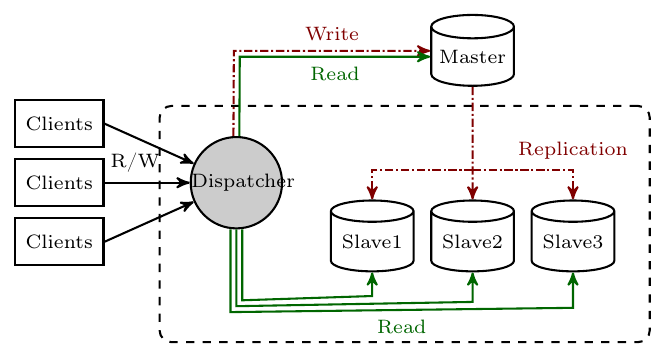

In [196]:
row = veritikz_dataset[i]
print(row["instruction"])
print(row["expected"])
open("notebooks/verifier_ds_creation/code.tex","w").write(row["solution"])
open("notebooks/verifier_ds_creation/originalcode.tex","w").write(row["original_template"])
display(row["solution_image"])
i+=1 

In [197]:
i

175

### some tests

In [6]:
test_row_code = ds.select([24])["template_solution_code"][0][0]
original_test_row_code = ds.select([25])["code"][0]
original_test_row_code

'\\documentclass[tikz,border=5]{standalone}\n\\usepackage{tikz}\n\\usetikzlibrary{\n                arrows.meta,\n                bending,\n                positioning\n               }\n\\tikzset{\n         > = Latex,\n         arrows = {[bend]},\n         signal/.style = coordinate,\n         sum/.style = {\n                       draw,\n                       circle,\n                       minimum size = 2mm\n                      },\n         block/.style = {\n                         draw,\n                         rectangle,\n                         minimum height = 2em,\n                         minimum width = 4em\n                        },\n         branch/.style = {\n                          sum,\n                          minimum size = 1mm,\n                          fill = black\n                         }\n        }\n\n\\begin{document}\n\n  \\begin{tikzpicture}[auto]\n\n    \\node[signal] (input) {};\n    \\node[sum, right = of input] (left sum) {};\n    \\node[block

In [ ]:
generate_all_incorrect_solutions(original_test_row_code,test_row_code)

In [ ]:
test_row = ds.select(range(24,100))
hu=test_row.map(create_incorrect_solutions,batched=True,batch_size=1,load_from_cache_file=False)
